In [1]:
#import all required packages
import os
import numpy as np
import re
import matplotlib.pyplot as plt

from astroquery.vizier import Vizier
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join, vstack, hstack
from astropy.coordinates import SkyCoord, search_around_sky, Angle
from astropy.coordinates.matching import _get_cartesian_kdtree

from regions import read_ds9, write_ds9, CircleSkyRegion


In [2]:
#directory where master catalogs (output of ExaminePhotTables notebook) exist
os.chdir('/home/matt/Data/SLP_GC_data/CAL_files/all')

wavelength=25

#load in the master catalogs
mastercatSEG=ascii.read('masterCatSeg_FromFields_'+str(wavelength)+'um.dat')
mastercatDAO=ascii.read('masterCatDao_FromFields_'+str(wavelength)+'um.dat')

In [3]:
#Source coordinates need to be in the form of skycoord objects. Ascii tables save as strings so this code puts them back in the right form. 
if mastercatSEG is not None:
    sourcecoords=mastercatSEG['sky_centroid']
else:
    sourcecoords=[]
scseg=[]

for coord in sourcecoords:
    pos=coord.find(",")
    ra=coord[:pos]
    dec=coord[pos+1:]
    scobj=SkyCoord(ra,dec,unit=u.deg)
    scseg.append(scobj)

if mastercatSEG is not None:
    mastercatSEG['skycoords']=scseg
    scseg=mastercatSEG['skycoords']
    
if mastercatDAO is not None:
    sourcecoords=mastercatDAO['sky_centroid']
else:
    sourcecoords=[]
scdao=[]

for coord in sourcecoords:
    pos=coord.find(",")
    ra=coord[:pos]
    dec=coord[pos+1:]
    scobj=SkyCoord(ra,dec,unit=u.deg)
    scdao.append(scobj)
    
mastercatDAO['skycoords']=scdao
scdao=mastercatDAO['skycoords']

In [4]:
#online catalog query
catalog_list = Vizier.find_catalogs('Spitzer IRAC survey of the galactic center')
print({k:v.description for k,v in catalog_list.items()})

#get the SSTGC catalog
Vizier.ROW_LIMIT = 1000000 #increased by factor of 10, otherwise no matches are returned
catalog_irac = Vizier.get_catalogs(catalog_list.keys())
print(catalog_irac)

sstgc = catalog_irac['II/295/SSTGC']
print(sstgc) 

{'II/295': 'Spitzer IRAC survey of the galactic center (Ramirez+, 2008)', 'J/ApJ/685/958': 'Spitzer and Chandra sources in galactic center (Arendt+ 2008)'}
TableList with 3 tables:
	'0:II/295/SSTGC' with 12 column(s) and 1000000 row(s) 
	'1:II/295/GC-IRAC' with 8 column(s) and 1000000 row(s) 
	'2:J/ApJ/685/958/table7' with 13 column(s) and 115 row(s) 
 SSTGC    RAJ2000     DEJ2000    Jmag    Hmag   ... _5.8mag _8.0mag IRAC _2M
          "h:m:s"     "d:m:s"    mag     mag    ...   mag     mag           
------- ----------- ----------- ------ -------- ... ------- ------- ---- ---
0000001 17 40 10.53 -29 32 49.2 16.204   13.493 ...      --      -- IRAC  2M
0000002 17 40 10.62 -29 31 46.3 14.699   13.021 ...      --      -- IRAC  2M
0000003 17 40 10.69 -29 32 57.4 14.558   12.976 ...      --      -- IRAC  2M
0000004 17 40 10.69 -29 30 49.5 14.059   11.925 ...      --      -- IRAC  2M
0000005 17 40 10.70 -29 31 12.1 13.900   13.339 ...      --      -- IRAC  2M
0000006 17 40 10.70 -29 31 39.

In [5]:
#add new skycoord object to the VIZIER table for easier use
ras=sstgc["RAJ2000"]
decs=sstgc["DEJ2000"]

scobj=SkyCoord(ras,decs,unit=(u.hr,u.deg))
sstgc["skycoords"]=scobj

#print catalog to see the new entry
sstgc

SSTGC,RAJ2000,DEJ2000,Jmag,Hmag,Ksmag,_3.6mag,_4.5mag,_5.8mag,_8.0mag,IRAC,_2M,skycoords
,"""h:m:s""","""d:m:s""",mag,mag,mag,mag,mag,mag,mag,,,"deg,deg"
str7,str11,str11,float32,float32,float32,float32,float32,float32,float32,str4,str2,object
0000001,17 40 10.53,-29 32 49.2,16.204,13.493,12.703,--,--,--,--,IRAC,2M,"265.043875,-29.547"
0000002,17 40 10.62,-29 31 46.3,14.699,13.021,12.393,--,--,--,--,IRAC,2M,"265.04425,-29.529527777777776"
0000003,17 40 10.69,-29 32 57.4,14.558,12.976,12.327,--,--,--,--,IRAC,2M,"265.0445416666667,-29.549277777777778"
0000004,17 40 10.69,-29 30 49.5,14.059,11.925,11.055,--,--,--,--,IRAC,2M,"265.0445416666667,-29.51375"
0000005,17 40 10.70,-29 31 12.1,13.900,13.339,11.957,--,--,--,--,IRAC,2M,"265.0445833333333,-29.520027777777777"
0000006,17 40 10.70,-29 31 39.0,15.886,13.522,12.824,--,--,--,--,IRAC,2M,"265.0445833333333,-29.5275"
...,...,...,...,...,...,...,...,...,...,...,...,...
0999995,17 49 32.30,-28 06 20.2,14.913,12.318,11.360,10.591,--,10.154,--,IRAC,2M,"267.3845833333333,-28.105611111111113"


In [6]:
#lets see if there are cross matches between the tables
SSTGCsources=sstgc['skycoords']
DAOsources=mastercatDAO['skycoords']

idx,rdx, d2d, d3d = DAOsources.search_around_sky(SSTGCsources, 4*u.arcsec)

print('Number of crossmatched sources found: ', len(idx))

Number of crossmatched sources found:  1325


In [7]:
#create new tables containing only the crossmatched sources
matchedSSTGC=sstgc[idx]
matchedDAO=mastercatDAO[rdx]

In [8]:
#Take the information we want from one table and put it in the other table
matchedDAO["Jmag"]=matchedSSTGC["Jmag"]
matchedDAO["Hmag"]=matchedSSTGC["Hmag"]
matchedDAO["Ksmag"]=matchedSSTGC["Ksmag"]


matchedDAO["_3.6mag"]=matchedSSTGC["_3.6mag"]
matchedDAO["_4.5mag"]=matchedSSTGC["_4.5mag"]
matchedDAO["_5.8mag"]=matchedSSTGC["_5.8mag"]
matchedDAO["_8.0mag"]=matchedSSTGC["_8.0mag"]

In [9]:
#print new table containing all the relevant data
matchedDAO

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,sky_centroid,skycoords,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,pixApArea,pixAnnArea,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv,Master_id,selfXmatch,Jmag,Hmag,Ksmag,_3.6mag,_4.5mag,_5.8mag,_8.0mag
,,,,,,,,,,,,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,mag,mag,mag,mag,mag
int64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,str38,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32
7,264.5,130.3,0.4881,-0.8288,-0.2334,25,0,0.01658,1.004,-0.003985,"266.09105908661354,-29.522800220462877","266.09105908661354,-29.522800220462877",0.052516401584878344,0.04619360363946583,-0.04271201779445526,0.09244780127560648,-0.030118663826312217,0.138686183518619,0.1401765841231883,0.1849557722302171,0.24586320509544823,0.23121960956849189,6.260301806606553e-05,0.0007526218717323834,-0.042122641990633806,0.138686183518619,6.260301806606553e-05,191.74759516631747,830.906245720709,-0.09781035570938083,0.05118262623328706,-0.04804711920082041,0.11883617849772772,0.21251882130566604,0.23182108902751564,-0.14633020014281606,0.22032006211752,0.32253314131368016,0.32253314131368016,C7Field1,25,41,0,13.084,12.435,11.787,--,--,--,--
6,262.0,111.5,0.418,0.2416,0.3381,25,0,0.01114,1.031,-0.0335,"266.0916781889667,-29.526800886338012","266.0916781889667,-29.526800886338012",0.10071641932395495,0.046432540020006324,0.3088268036374314,0.09478885259648308,0.8583478988159605,0.1445046471569166,1.6095473372991502,0.19465527705000837,2.1578833760783525,0.24481075467415483,0.0014210492372512817,0.0020387204519179284,0.5858651249600976,0.1445046471569166,0.0014210492372512815,191.74759516631747,830.906245720709,0.8178014083505272,0.07044055556219239,0.18772334859038123,1.1251335171109496,1.4009867820342885,0.25113289759076646,0.38476697060444454,1.1497357548962794,1.0927125333497505,1.1497357548962794,C7Field1,25,40,0,--,--,--,13.068,--,--,--
7,264.5,130.3,0.4881,-0.8288,-0.2334,25,0,0.01658,1.004,-0.003985,"266.09105908661354,-29.522800220462877","266.09105908661354,-29.522800220462877",0.052516401584878344,0.04619360363946583,-0.04271201779445526,0.09244780127560648,-0.030118663826312217,0.138686183518619,0.1401765841231883,0.1849557722302171,0.24586320509544823,0.23121960956849189,6.260301806606553e-05,0.0007526218717323834,-0.042122641990633806,0.138686183518619,6.260301806606553e-05,191.74759516631747,830.906245720709,-0.09781035570938083,0.05118262623328706,-0.04804711920082041,0.11883617849772772,0.21251882130566604,0.23182108902751564,-0.14633020014281606,0.22032006211752,0.32253314131368016,0.32253314131368016,C7Field1,25,41,0,14.587,13.694,11.978,10.056,9.896,9.458,9.686
4,251.1,99.84,0.4994,-0.3837,-0.2673,25,0,0.0132,1.09,-0.0934,"266.0943356225441,-29.52929433422169","266.0943356225441,-29.52929433422169",0.0644969271019883,0.046690704206011395,-0.13722228928089028,0.09458863403860254,-0.10849647118487549,0.143827679806591,0.2664597041645692,0.19364012711126843,0.8329172022993689,0.24377129924506946,0.002656686325706302,0.0033276786979738212,-0.6179096852502989,0.143827679806591,0.002656686325706302,191.74759516631747,830.906245720709,-0.6891281729533231,0.00789545887249682,-0.36362816219885624,-0.6391637875072945,-0.5821195034379185,0.02425749651708434,-0.6112329901680185,-0.5133483766021781,-0.35282260768997065,0.02425749651708434,C7Field1,25

In [10]:
#write out the new matched catalog
ascii.write(matchedDAO,"masterDAOxmatchSSTGC.dat")

In [11]:
#lets take a look at positional accuracy
deltaRA=matchedDAO['skycoords'].ra.deg - matchedSSTGC['skycoords'].ra.deg
deltaDEC=matchedDAO['skycoords'].dec.deg - matchedSSTGC['skycoords'].dec.deg

print("Average difference in RA: ", np.mean(deltaRA), ",  Standard deviation of difference: ", np.std(deltaRA))
print("Average difference in DEC: ", np.mean(deltaDEC), ",  Standard deviation of difference: ", np.std(deltaDEC))

Average difference in RA:  1.919046969301492e-05 ,  Standard deviation of difference:  0.0006085844897949233
Average difference in DEC:  1.9843519370598286e-05 ,  Standard deviation of difference:  0.0005161281168260086


In [12]:
#define a 'fancy' scatter+histogram plot
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 1e-4
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(deltaRA, bins=bins)
    ax_histy.hist(deltaDEC, bins=bins, orientation='horizontal')

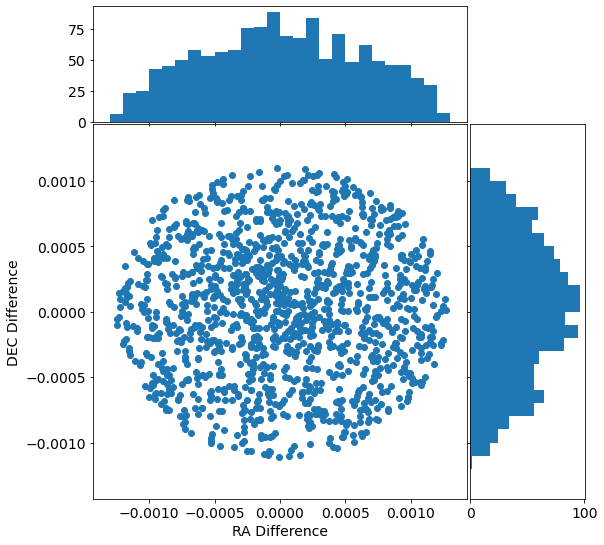

In [13]:
#make the scatter+hist plot for position x-match
plt.rcParams.update({'font.size': 14})

# definitions for the axes
left, width = 1e-5, 0.65
bottom, height = 0.0001, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(deltaRA, deltaDEC, ax, ax_histx, ax_histy)

ax.set_xlabel('RA Difference')
ax.set_ylabel('DEC Difference')

plt.show()


In [14]:
#add 25 micron magnitude -> Simple calculation that probably needs refinement...
zp=6.2
matchedDAO["aper_4as_mag"] = np.round(-2.5*np.log10(matchedDAO["aper_sum_bkgsub_4as"]/zp),3)

#calculated 8-25 color
matchedDAO["8-25mag"]=matchedDAO["_8.0mag"]-matchedDAO["aper_4as_mag"]

/tmp/ipykernel_11270/758410295.py:3: RuntimeWarning: invalid value encountered in log10
  matchedDAO["aper_4as_mag"] = np.round(-2.5*np.log10(matchedDAO["aper_sum_bkgsub_4as"]/zp),3)


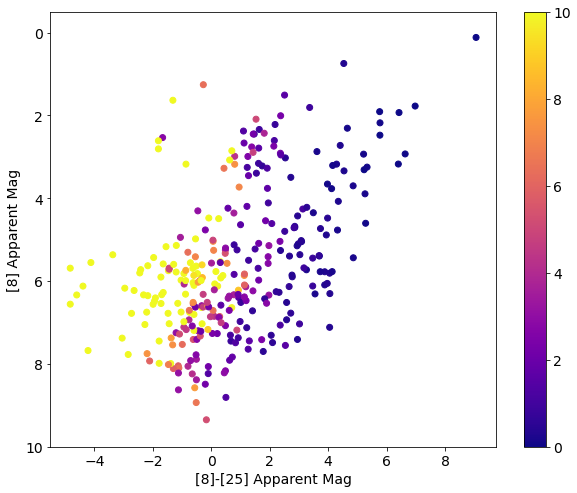

In [15]:
#A rough 8-25 vs 8 CMD -> Note that these are apparent mags rather than absolute
plt.figure(figsize=(10,8))
plt.scatter(matchedDAO["aper_4as_mag"],matchedDAO["8-25mag"],c=matchedDAO['aper_snr_4as'], cmap='plasma')
plt.colorbar()
plt.clim(0,10)
plt.ylim(10,-0.5)
plt.xlabel('[8]-[25] Apparent Mag')
plt.ylabel('[8] Apparent Mag')
plt.show()

In [16]:
#lets look at some sources above/below an snr cut
cutoff=3.0
lowsnr=matchedDAO['aper_snr_4as']<cutoff 
highsnr=matchedDAO['aper_snr_4as']>=cutoff 

xmatchlowSNR=matchedDAO[lowsnr] #apply snr cut
xmatchhighSNR=matchedDAO[highsnr] #apply snr cut

In [17]:
#function to write color coded ds9 files
def makeDS9file(savename, table, radius, color='green'):
    scs=table['skycoords']
    
    #loop through and create region instances for each source
    regions=[]
    for i in range(0,len(scs)):
        region = CircleSkyRegion(scs[i], radius)
        regions.append(region)
        
    #write out region file
    write_ds9(regions, savename)
    
    #change the color of the regions to red - no built in way to do this in regions package :-/
    with open(savename, 'r+') as f:
        text = f.read()
        text = re.sub(r'\)', r') # color='+color, text)
        f.seek(0)
        f.write(text)
        f.truncate()

In [18]:
#write out save ds9 region files

#set size of regions 
r = Angle(0.00083333, u.deg) #must be in degrees - current value is r=3"
#write out ds9 files
makeDS9file('xmatch_cat_snrlow_'+str(wavelength)+'.reg', xmatchlowSNR, r, color='red')
makeDS9file('xmatch_cat_snrhigh_'+str(wavelength)+'.reg', xmatchhighSNR, r, color='yellow')